## ***Visión por Computadora - 2024***

Stefano Aragoni, Carol Arévalo, José González, Luis Santos

-----------

### *Proyecto 01 - Problema 1*

A partir de las imágenes groundtruth, construir un algoritmo que genere una discretización de la estructura arterial. Representaremos esta discretizaiónn mediante un grafo de vértices y aristas que conectan dichos vértices.

Su algoritmo debe recibir como input la imagen groundtruth, y los par´ametros espec´ıficos que sus m´etodos y estrategias requieran.

Como salida, el algoritmo debe devolver lo siguiente:

1.) Un archivo estructurado (puede ser en formato .json, .yml, o similares), en donde se especifica la estructura del grafo
obtenido:
- listado de nodos, y sus coordenadas (fila, columna) dentro de la imagen groundtruth.
- listado de nodos extremos (indicados en verde en la figura).
- listado de nodos de bifurcación (indicados en rojo en la figura).
- listado de nodos de trifurcación (indicados en azul, en la figura no hay).
- listado de nodos intermedios (indicados en gris en la figura). Estos nodos se añaden a conveniencia, para mantener el grafo resultante lo más similar a la estructura arterial en la imagen.
- listado de aristas conectoras que conforman el grafo (indicadas en amarillo en la imagen).

2.) Una imagen que guarde la visualización del grafo obtenido.





-----------

#### *Importar librerías*

Como primer paso, se importan las librerías necesarias para el desarrollo del problema.

In [174]:
import os

import matplotlib.pyplot as plt
import numpy as np

import cv2
from scipy import ndimage
from PIL import Image

from skimage import io, color, filters, feature, morphology, exposure, util
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.util import invert
from skimage.filters import threshold_otsu, gaussian, threshold_local
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, disk, remove_small_objects
from skimage.graph import route_through_array


from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

---------

#### *Cargar imágenes*

Luego, se procede a cargar las imágenes que se utilizarán para el desarrollo del problema.

- Para llevar a cabo este proceso, se definió una función llamada `load_images`. Esta recibe como parámetro el nombre de la imagen a cargar y retorna la imagen en escala de grises.

In [175]:
def load_image(name_of_image):

    # Definir el directorio de la base de datos
    directory = "./database"

    # Importar imagen en escala de grises
    image = cv2.imread(os.path.join(directory, name_of_image), cv2.IMREAD_GRAYSCALE)

    #Retornar imagen
    return image

- Posteriormente, se definió un ciclo `for` para cargar las 40 imágenes que se utilizarán para el desarrollo del problema.

In [176]:
# Array para almacenar las imagenes groundtruth
groundtruth_images = []
processed_images = []

# Cargar imagenes
for i in range(1, 21):
    
    groundtruth = f"{i}_gt.pgm"

    gt = load_image(groundtruth) > 0
    groundtruth_images.append(gt)

- Finalmente, se programó una función para mostrar las imágenes cargadas.

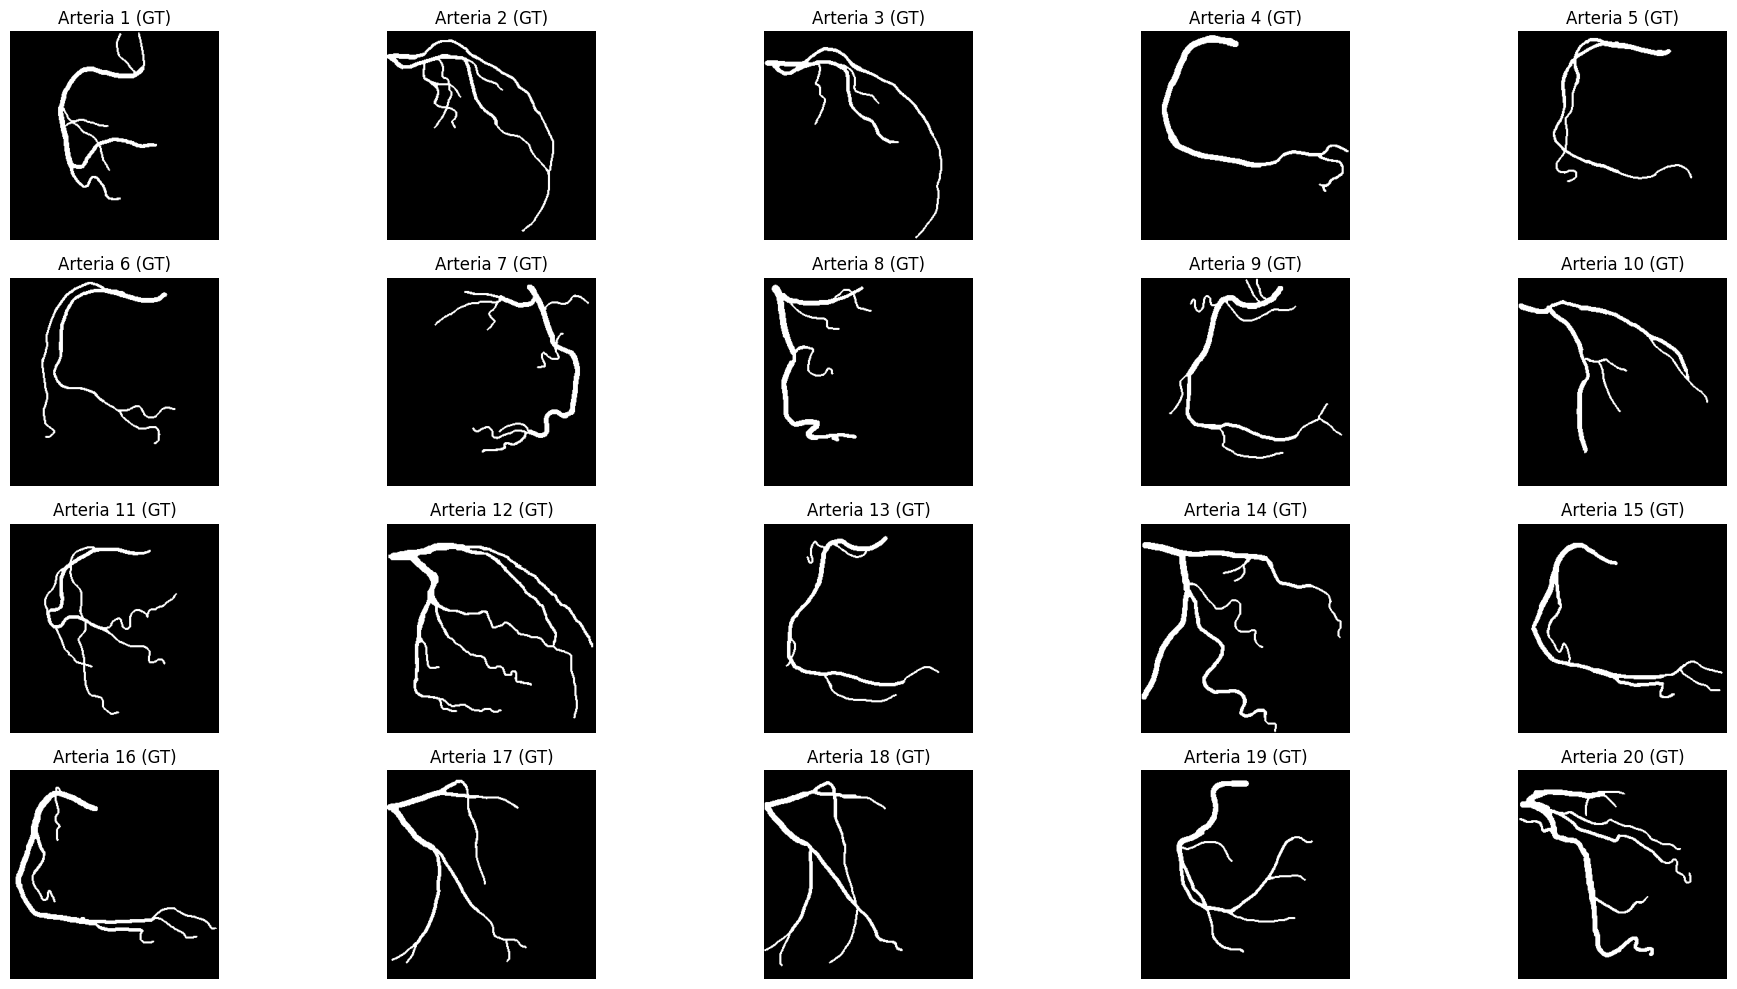

In [177]:

num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes y mostrarlas en la cuadrícula
for i in range(0, 20):  
    groundtruth_img = groundtruth_images[i]

    # Mostrar imagen groundtruth
    axes[index // num_cols, index % num_cols].imshow(groundtruth_img, cmap='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (GT)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()

plt.show()


*Como se puede observar, hay varias imágenes originales en las que se ve el borde del microscopio (contornos negros en las esquinas). Asimismo, hay varias imágenes con manchas y sombras que pueden afectar el proceso de binarización. Como resultado, será necesario pre-procesar las imágenes.*

---------

#### *Pre-Procesamiento de Imágenes*

Posteriormente, se procede eliminar artefactos y ruido de las imágenes. 

- Como primer punto, se procede a aplicar un filtro gaussiano para suavizar la imagen y luego umbralizarla para obtener una imagen binaria que separe las arterias del fondo. Esto para binarizar la imagen, manteniendo las arterias y eliminando el fondo.

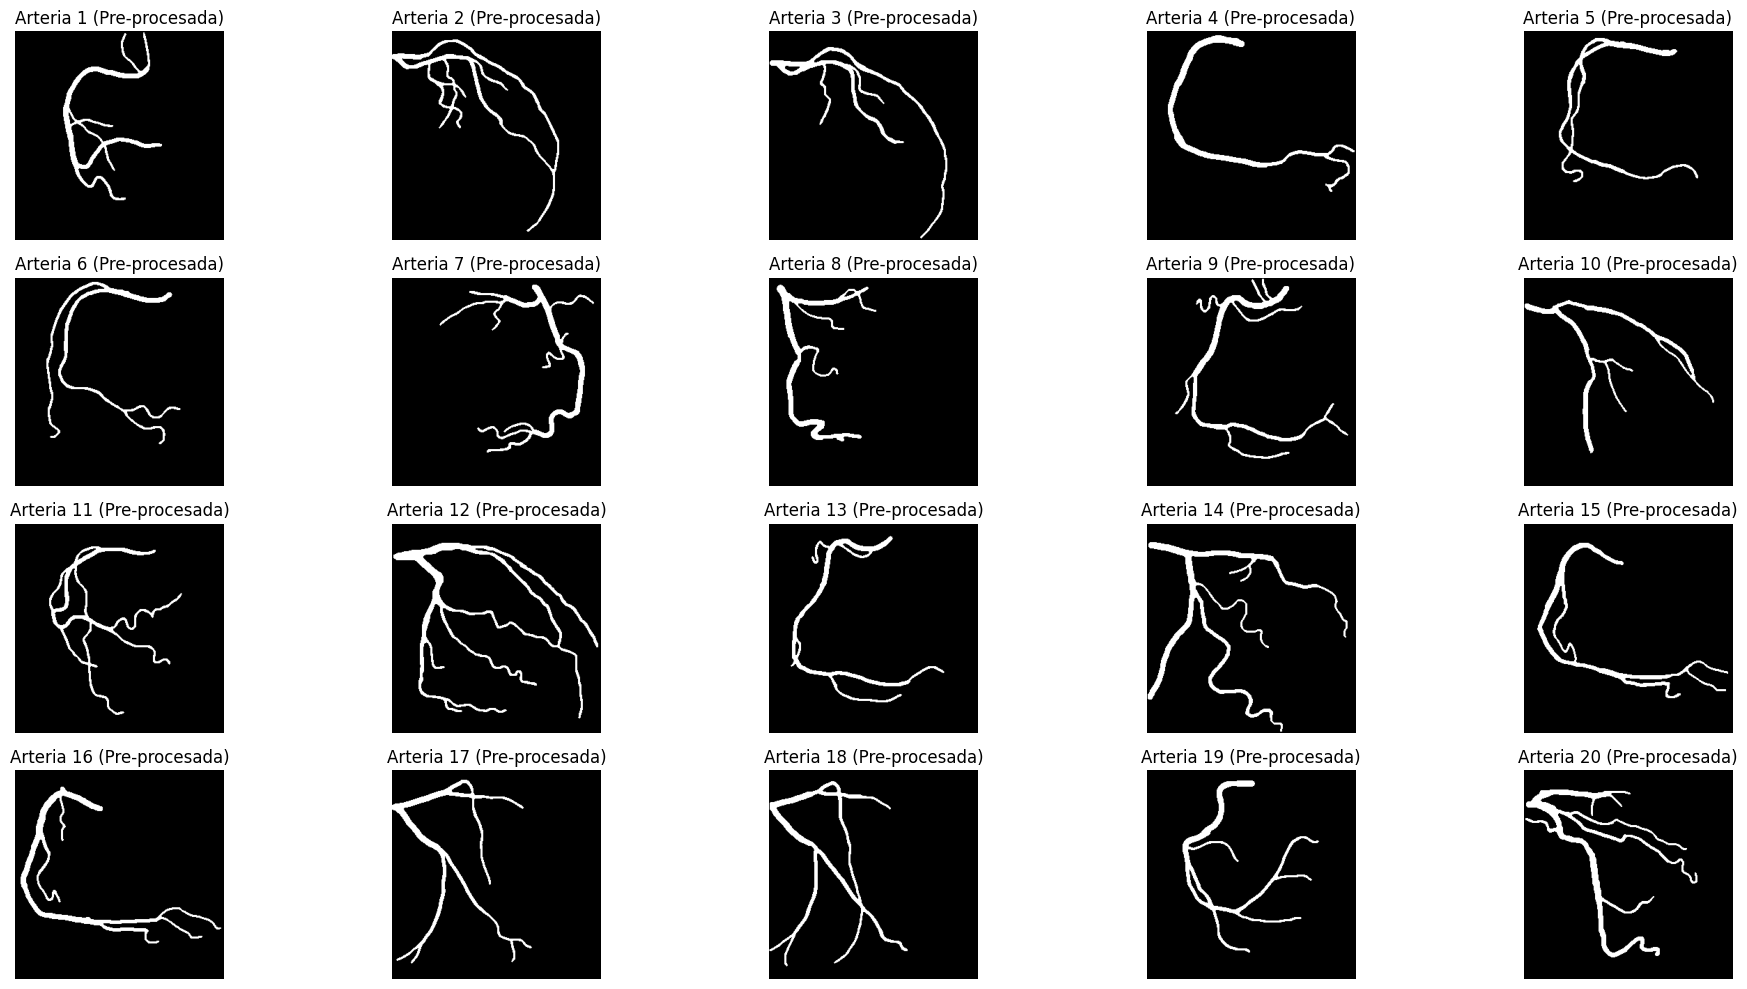

In [178]:
# Aplicar un filtro gaussiano para suavizar la imagen
smoothed_images = [gaussian(image, sigma=1) for image in groundtruth_images]

# Aplicar umbralización para convertir las imágenes a binario
# Este umbral puede ser global (simple) o adaptativo (local) dependiendo de las imágenes
thresholded_images = [image > threshold_otsu(image) for image in smoothed_images]

# Mostrar las imágenes pre-procesadas
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes pre-procesadas y mostrarlas en la cuadrícula
for i in range(20):  
    # Mostrar imagen pre-procesada
    axes[index // num_cols, index % num_cols].imshow(thresholded_images[i], cmap='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Pre-procesada)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()


---------

#### *Detección de características*

Detectar puntos extremos, bifurcaciones y posiblemente trifurcaciones usando la transformada de Hough para detectar curvas o utilizando un análisis de la estructura de la imagen (como el análisis de esqueleto).

- Esqueletización: Se convierten las arterias a su forma esquelética, que es una representación de un píxel de ancho de las arterias.

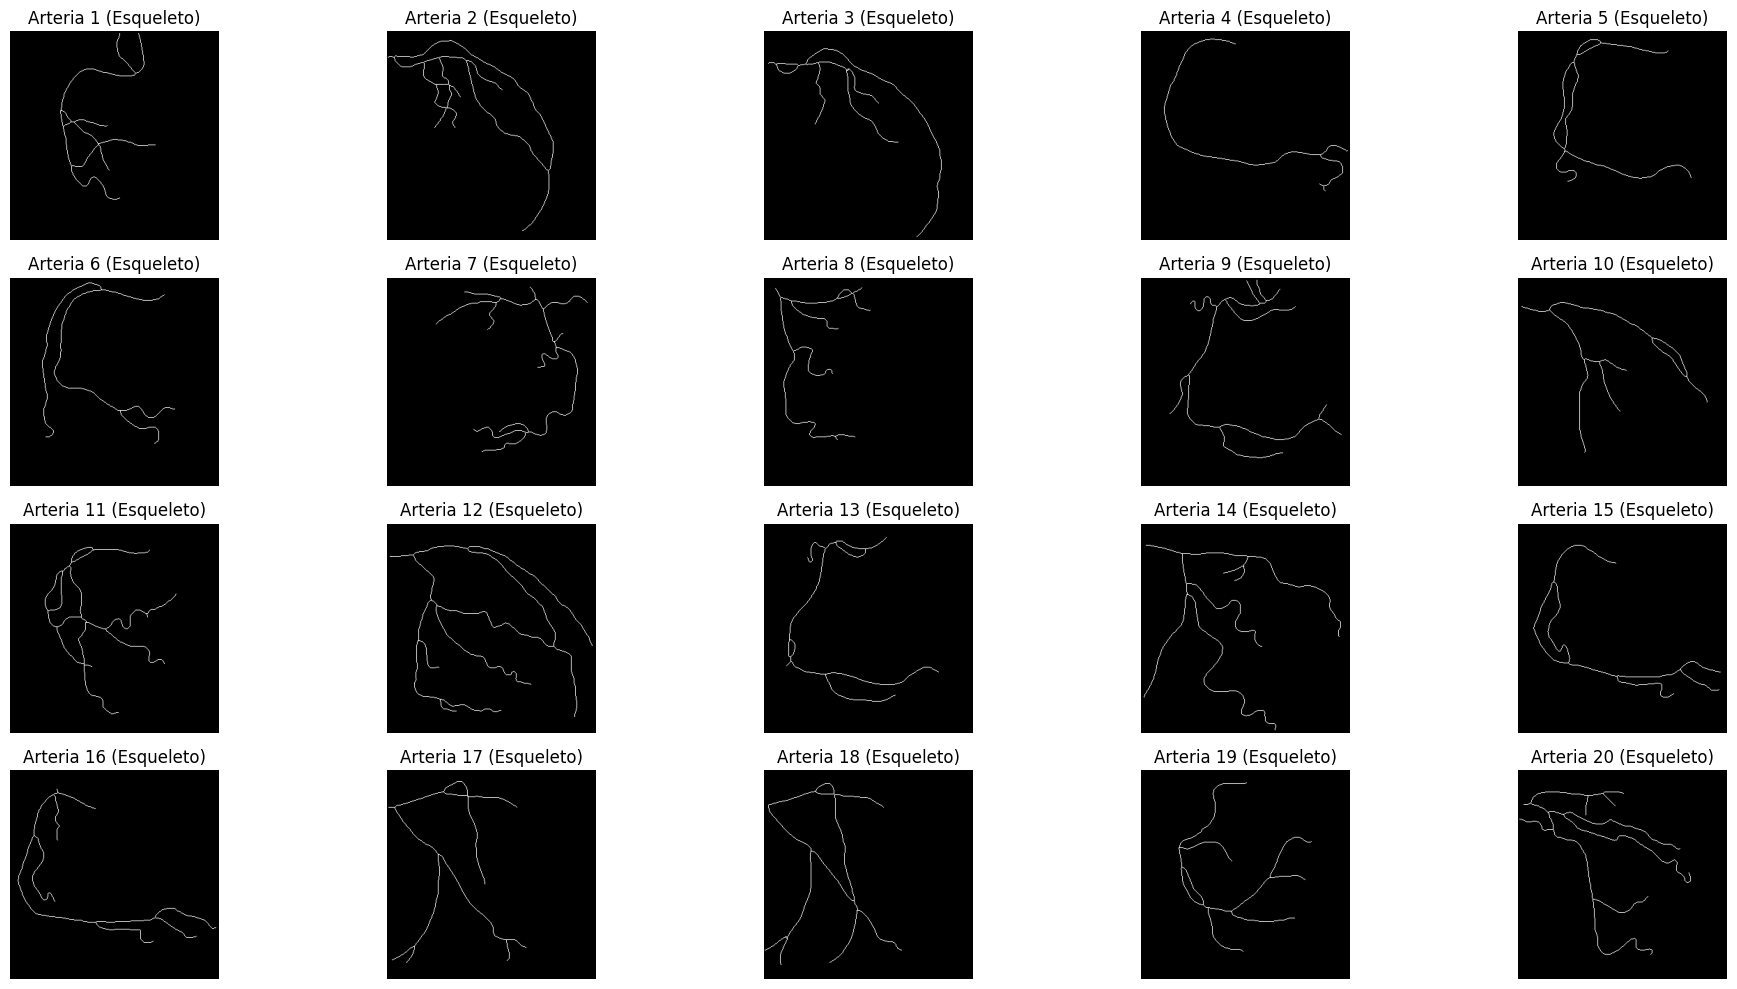

In [179]:
from skimage.morphology import skeletonize

skeleton_images = [skeletonize(image) for image in thresholded_images]

# Mostrar las imágenes esqueletizadas
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes esqueletizadas y mostrarlas en la cuadrícula
for i in range(20):  # Asumiendo que hay 20 imágenes
    # Mostrar imagen esqueletizada
    axes[index // num_cols, index % num_cols].imshow(skeleton_images[i], cmap='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Esqueleto)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()


- Análisis de esqueleto: Se analiza el esqueleto para identificar nodos y conexiones. Los puntos de bifurcación son puntos donde un píxel tiene más de dos vecinos en el esqueleto, y los puntos extremos son aquellos que solo tienen un vecino.

# Detecion de trifurcaciones

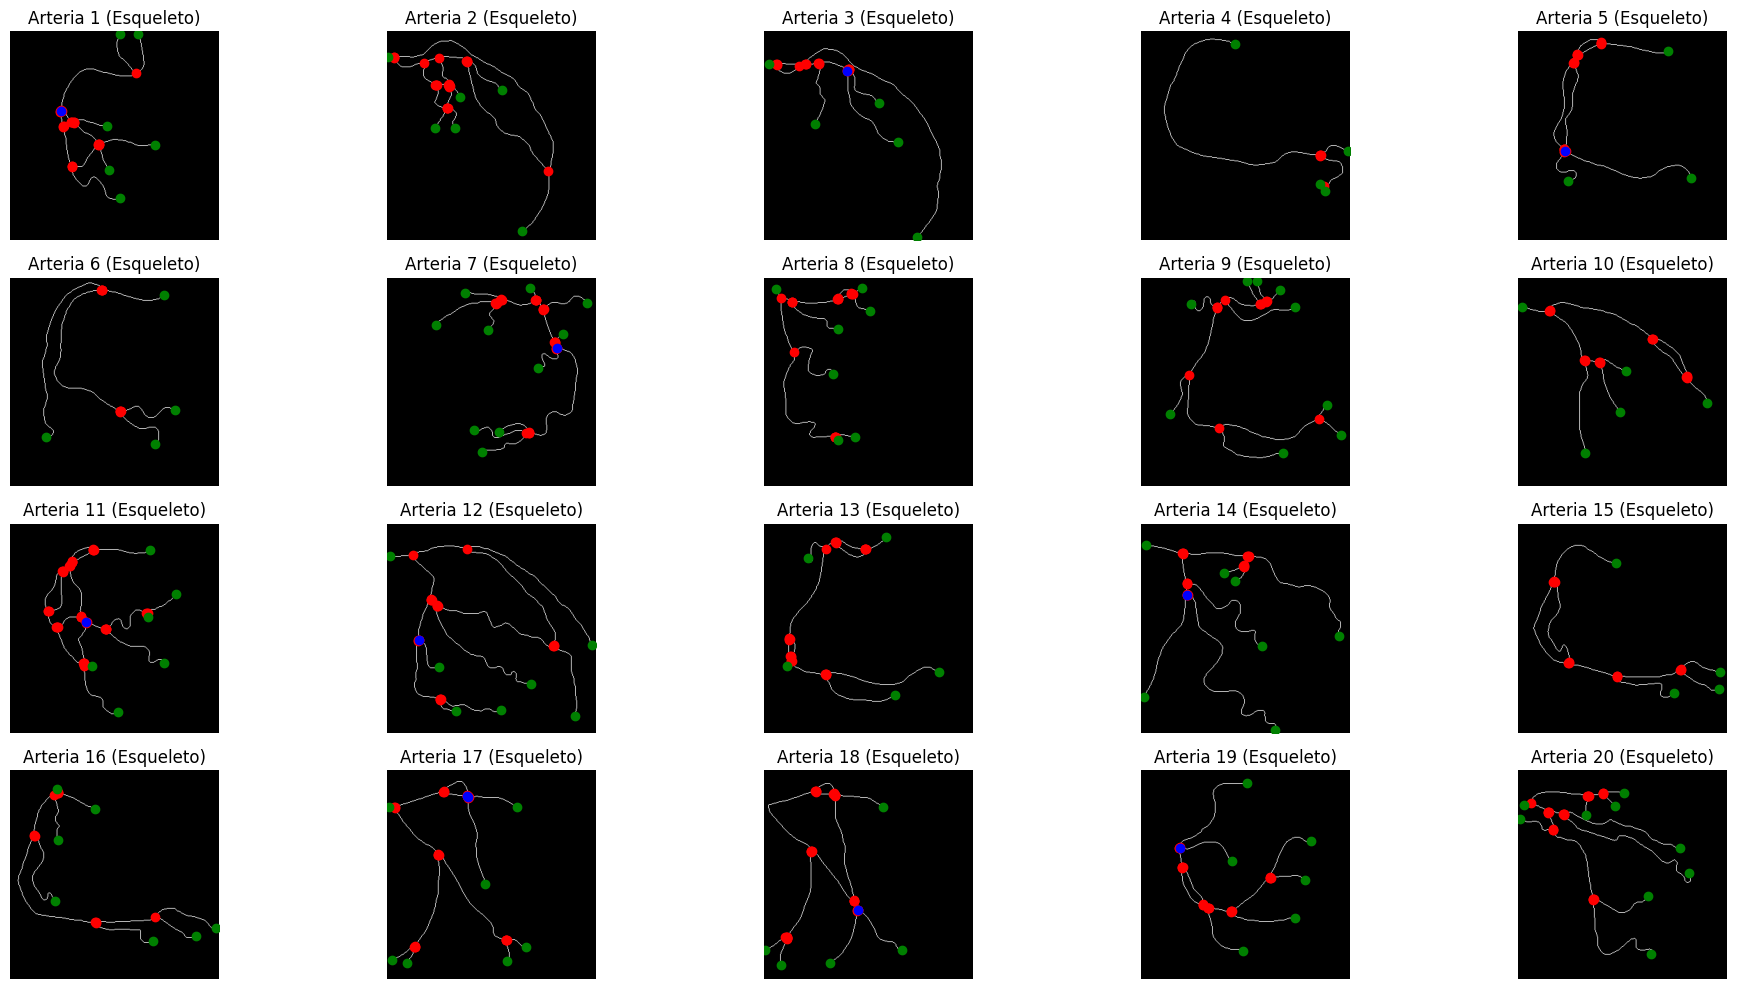

In [182]:

def analyze_skeleton(skeleton):
    # Preparar arrays para almacenar las coordenadas de los puntos
    bifurcation_points = []
    endpoint_points = []
    trifurcation_points = []  # Agregar lista para puntos de trifurcación
    
    # Obtener las dimensiones de la imagen
    dimensions = skeleton.shape
    
    # Analizar cada píxel del esqueleto
    for i in range(1, dimensions[0]-1):
        for j in range(1, dimensions[1]-1):
            # Contar los vecinos del píxel
            p = skeleton[i, j]
            neighbors = skeleton[i-1:i+2, j-1:j+2].sum() - p
            # Si el píxel es parte del esqueleto y tiene exactamente un vecino, es un extremo
            if p == 1 and neighbors == 1:
                endpoint_points.append((j, i))
            # Si el píxel es parte del esqueleto y tiene exactamente tres vecinos, es una bifurcación
            elif p == 1 and neighbors == 3:
                bifurcation_points.append((j, i))
            # Si el píxel es parte del esqueleto y tiene exactamente cuatro vecinos, es una trifurcación
            elif p == 1 and neighbors == 4:
                # Analizar la configuración de los vecinos para determinar si es una 'T' o una cruz
                neighbor_positions = [
                    skeleton[i-1, j], skeleton[i+1, j], # Arriba y abajo
                    skeleton[i, j-1], skeleton[i, j+1], # Izquierda y derecha
                    skeleton[i-1, j-1], skeleton[i-1, j+1], # Diagonales superiores
                    skeleton[i+1, j-1], skeleton[i+1, j+1]  # Diagonales inferiores
                ]
                # Contar cuántos de los puntos diagonales están activos
                diagonal_neighbors = neighbor_positions[4:].count(1)
                # Si hay exactamente un vecino diagonal activo, es una 'T', por lo tanto, una trifurcación
                if diagonal_neighbors == 1:
                    trifurcation_points.append((j, i))
                else:
                    # Es una bifurcación o un punto con conexión cruzada, pero no una trifurcación
                    bifurcation_points.append((j, i))
    
    return bifurcation_points, endpoint_points, trifurcation_points


# Encontrar puntos de bifurcación, extremos y trifurcación
analized_skeleton_images = [analyze_skeleton(image) for image in skeleton_images]

# Mostrar las imágenes esqueletizadas con puntos de bifurcación, extremos y trifurcación
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes esqueletizadas y mostrarlas en la cuadrícula
for i in range(20):  # Asumiendo que hay 20 imágenes
    skeleton_image = skeleton_images[i]  # Esta es la imagen esqueletizada
    bifurcations, endpoints, trifurcations = analized_skeleton_images[i]  # Estos son los puntos detectados

    # Mostrar imagen esqueletizada
    axes[index // num_cols, index % num_cols].imshow(skeleton_image, cmap='gray')
    if bifurcations:
        axes[index // num_cols, index % num_cols].scatter(*zip(*bifurcations), color='red', label='Bifurcaciones')
    if endpoints:
        axes[index // num_cols, index % num_cols].scatter(*zip(*endpoints), color='green', label='Extremos')
    if trifurcations:
        axes[index // num_cols, index % num_cols].scatter(*zip(*trifurcations), color='blue', label='Trifurcaciones')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Esqueleto)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()

- Añadir nodos intermedios: Se añaden nodos intermedios a lo largo de los segmentos arteriales para preservar la geometría de la arteria en el grafo.

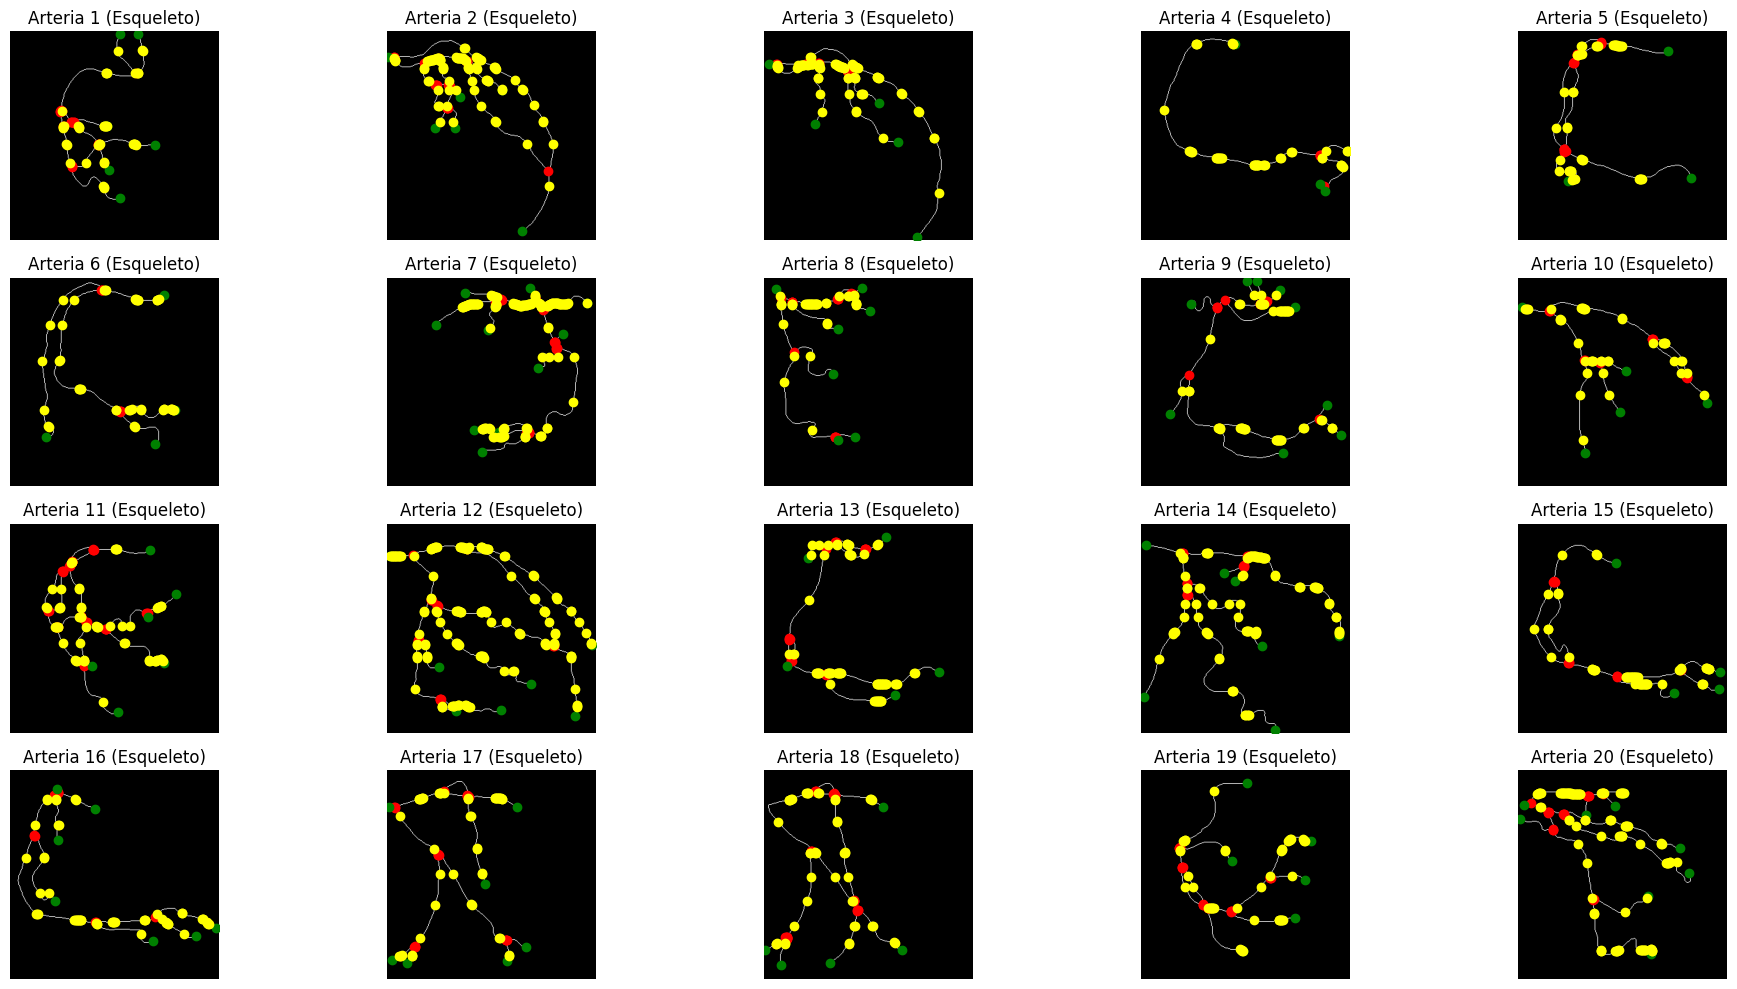

In [230]:
# Función para nodos intermedios a la visualización
def addIntermediateNodes(skeleton, bifurcations, trifurcations):
    dimensions = skeleton.shape
    intermediatePoints = []
    count = 50

    for i in range(1, dimensions[0]-1):
        inLine = 0
        for j in range(1, dimensions[1]-1):
            if skeleton[i][j] and [j, i] not in bifurcations and [j, i] not in trifurcations:
                count = count + 1
                if count % 100 == 0:
                    neighborsX = skeleton[i-1:i, 0:dimensions[0]].sum()

                    if neighborsX > 1 and inLine < neighborsX - 1:
                        inLine = inLine + 1
                        count = count - 1

                    intermediatePoints.append([j, i])

    return intermediatePoints

# Mostar nodos intermedios
completed_skeleton_images = []
for skeleton, data in zip(skeleton_images, analized_skeleton_images):
    bifurcations, _, trifurcations = data
    visualized_image = addIntermediateNodes(skeleton, bifurcations, trifurcations)
    completed_skeleton_images.append(visualized_image)

# Mostrar las imágenes esqueletizadas con puntos de bifurcación y extremos
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes esqueletizadas y mostrarlas en la cuadrícula
for i in range(20):  # Asumiendo que hay 20 imágenes
    skeleton_image = skeleton_images[i]  # Esta es la imagen esqueletizada
    bifurcations, endpoints, _ = analized_skeleton_images[i]   #bifuraciones y enpoints
    intermediate_nodes = completed_skeleton_images[i] # puntos intermdios
    axes[index // num_cols, index % num_cols].imshow(skeleton_image, cmap='gray')
    axes[index // num_cols, index % num_cols].scatter(*zip(*bifurcations), color='red')
    axes[index // num_cols, index % num_cols].scatter(*zip(*endpoints), color='green')
    if intermediate_nodes:
        axes[index // num_cols, index % num_cols].scatter(*zip(*intermediate_nodes), color='yellow')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Esqueleto)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()


- Se conectan aristan para formar el grafo usando Dijsktra

# FALTA

In [ ]:
#Conectar los puntos de inicio y fin de los tramos con cambio de dirección
def connectPoints(skeleton, endpoints, intermediate_nodes):
    # Crear una matriz de ceros con el mismo tamaño que la imagen
    connected_skeleton = np.zeros_like(skeleton)

    # Crear una copia de la lista de puntos intermedios
    intermediate_nodes = intermediate_nodes.copy()

    # Iterar sobre los puntos finales
    for endpoint in endpoints:
        # Crear una lista de puntos que conecta el punto final con los puntos intermedios
        path = route_through_array(
            skeleton, 
            start=endpoint, 
            end=intermediate_nodes, 
            fully_connected=True
        )[0]

        # Agregar el punto final y los puntos intermedios a la lista de puntos conectados
        connected_skeleton[tuple(zip(*path))] = 1

        # Eliminar los puntos intermedios de la lista de puntos intermedios
        for node in intermediate_nodes:
            if node in path:
                intermediate_nodes.remove(node)

    return connected_skeleton

# Conectar los puntos de inicio y fin de los tramos con cambio de dirección 
connected_skeleton_images = [connectPoints(skeleton, endpoints, intermediate_nodes) for skeleton, (_, endpoints, _) in zip(skeleton_images, analized_skeleton_images)]

# Mostrar las imágenes esqueletizadas con puntos de bifurcación y extremos
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes esqueletizadas y mostrarlas en la cuadrícula
for i in range(20):  # Asumiendo que hay 20 imágenes
    skeleton_image = connected_skeleton_images[i]  # Esta es la imagen esqueletizada
    bifurcations, endpoints, _ = analized_skeleton_images[i]   #bifurcaciones y enpoints
    axes[index // num_cols, index % num_cols].imshow(skeleton_image, cmap='gray')
    axes[index // num_cols, index % num_cols].scatter(*zip(*bifurcations), color='red')
    axes[index // num_cols, index % num_cols].scatter(*zip(*endpoints), color='green')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Esqueleto)')

    # Aumentar el contador de subfiguras
    index += 1

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()

---------

#### *Construcción del grafo:*
Se utilizan los puntos identificados para construir un grafo en formato json
